# Hunyuan-DiT 训练示例教程


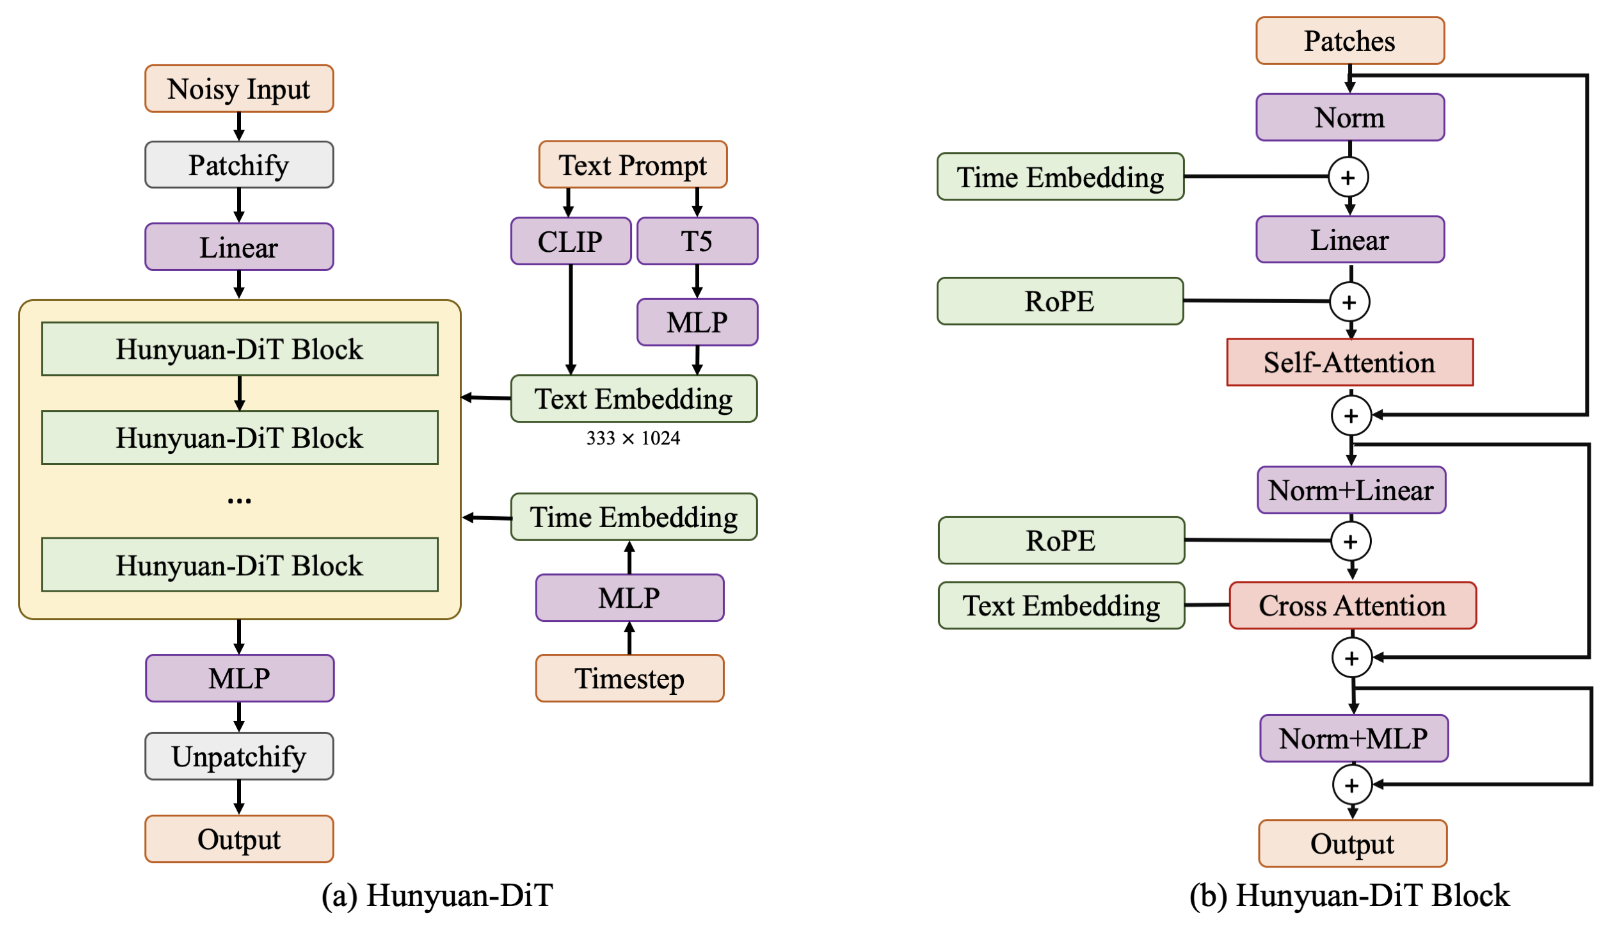

## 1. 进入环境 

In [ ]:
# （务必）开局必运行，否则找不到代码环境
import os

current_directory = os.path.basename(os.getcwd())
if current_directory != "HunyuanDiT":
    os.chdir('./HunyuanDiT')
    print("已进入")
else:
    print("已经在对应位置")

使用下面的命令下载从huggingface下载模型权重 （包含文本编码器clip、t5，图像编解码器vae权重等）


In [ ]:
! mkdir ckpts
! huggingface-cli download Tencent-Hunyuan/HunyuanDiT-v1.2 --local-dir ./ckpts

从这里手动下载蒸馏版模型并放到本地 (路径 "/HunyuanDiT/ckpts/t2i/model/pytorch_model_distill.pt")  
https://huggingface.co/Tencent-Hunyuan/Distillation-v1.2/tree/main
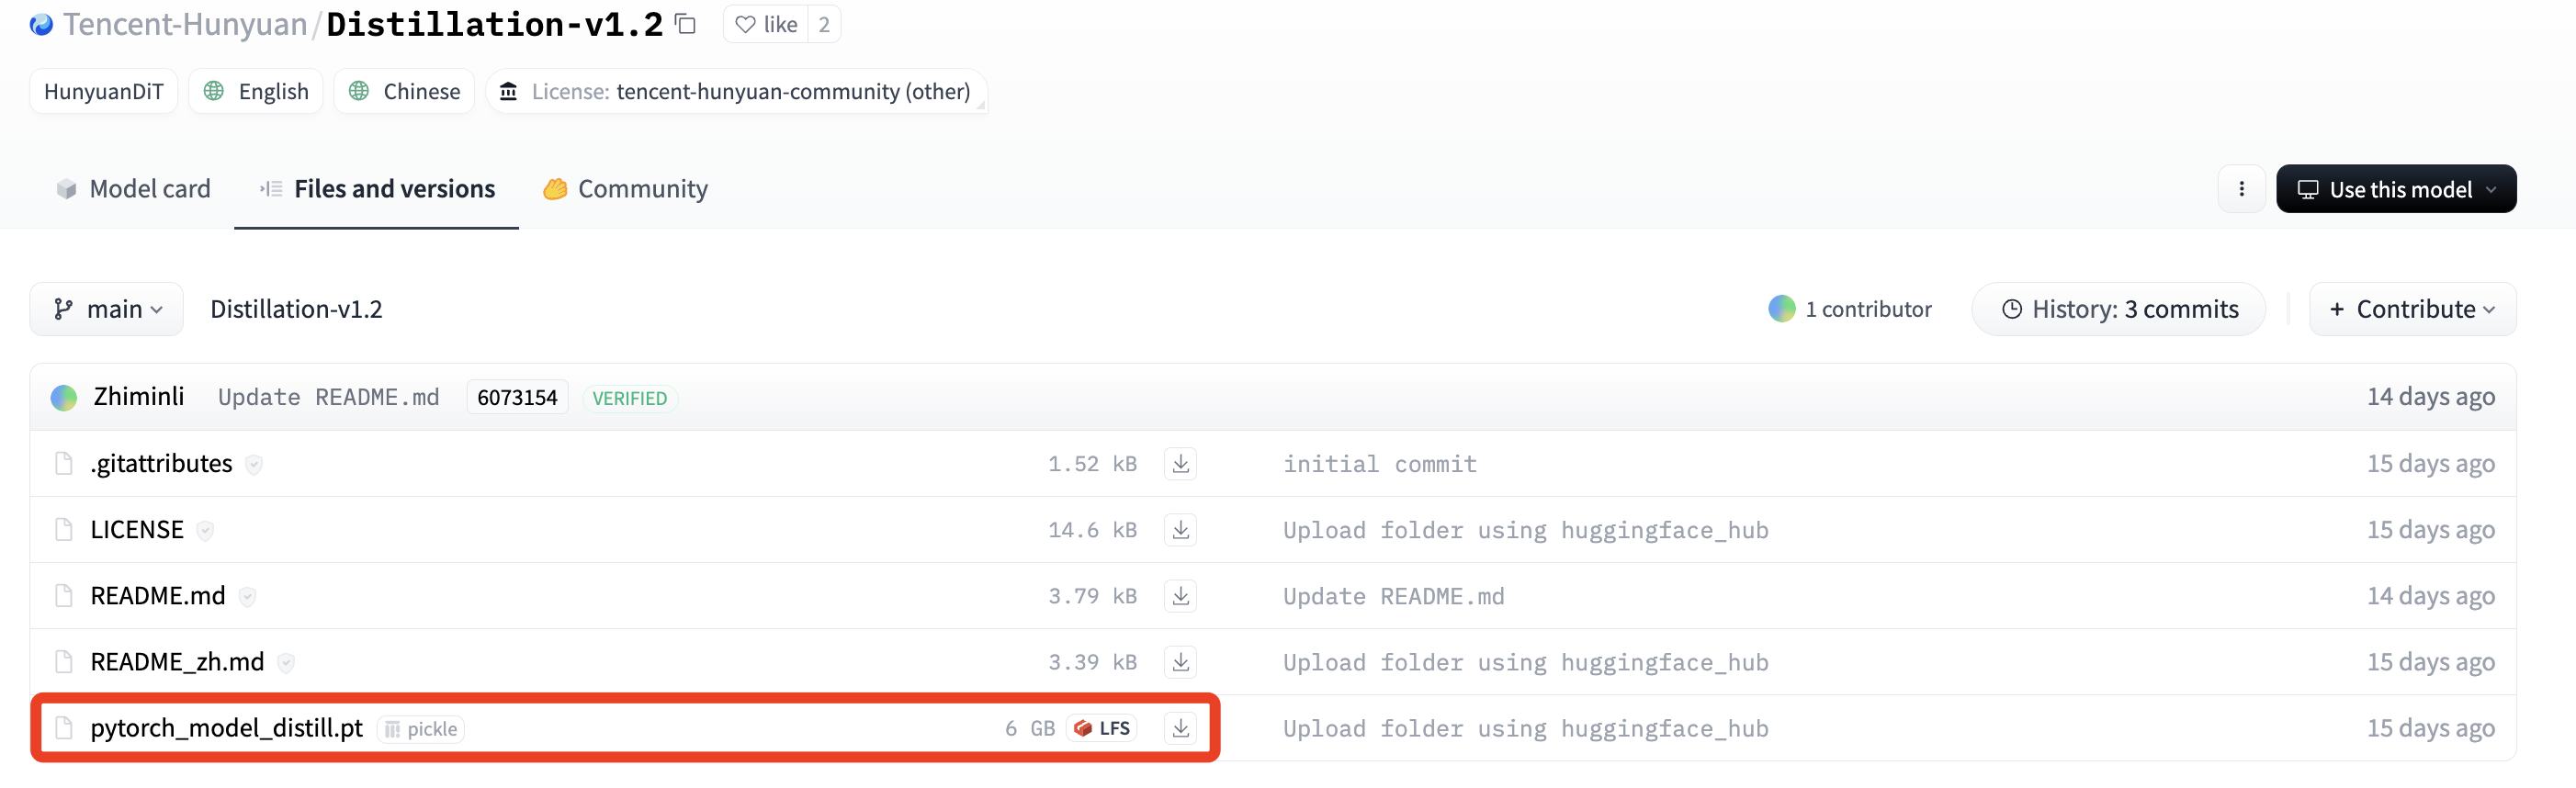

## 2. 数据集准备

安装数据加载器依赖包 （用于训练时读取图片和文本描述数据）

In [ ]:
! pip install -e ./IndexKits

样例图片数据下载

In [ ]:
! wget -O ./dataset/data_demo.zip https://dit.hunyuan.tencent.com/download/HunyuanDiT/data_demo.zip
! unzip -o ./dataset/data_demo.zip -d ./dataset
! mkdir ./dataset/porcelain/arrows ./dataset/porcelain/jsons
! echo "样例数据下载完成！"

图片描述器 （数据打标）

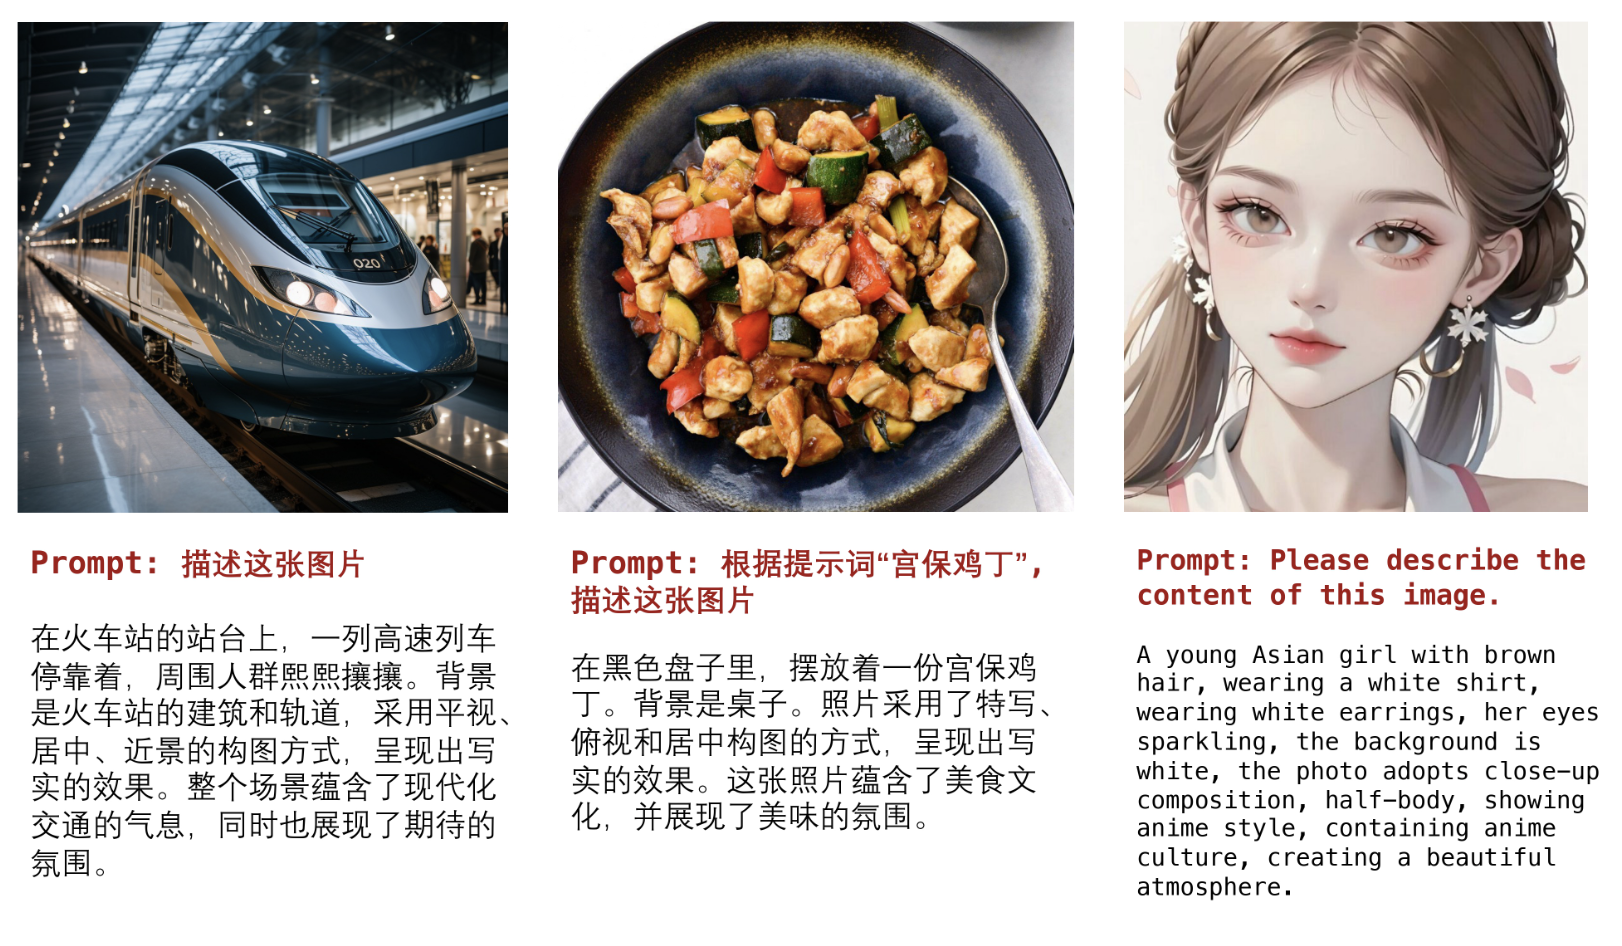

In [ ]:
# (可不运行) 随便推一张数据集中的图，看看ai给出的描述情况
! python mllm/caption_demo.py --mode "caption_zh" --image_file "mllm/images/demo1.png" --model_path "./ckpts/captioner"
# 其中--image_file "mllm/images/demo1.png"替换为你要测试的图片样例路径

### 以青花瓷数据集为例
PS：如果想用自己的数据训练，可以直接简单替换./dataset/porcelain/images下的所有图片为自己上传的图片后，重新运行以下代码 （小白推荐）  
或者自己仿照./dataset/porcelain的文件夹，建立自己的数据集文件夹，以深入了解其思想

In [ ]:
# 谨慎运行以下代码！会删除所有原先图片数据的指令, 以方便自行上传图片数据训练
! rm -rf ./dataset/porcelain/images/*  && echo "清空原有数据完成"

In [ ]:
# 这里仅仅是例子，把wukong的demo数据集用于学习
! cp ../demo_images_wukong/*.png ./dataset/porcelain/images/ && echo "复制数据完成"

In [ ]:
### 把图片路径记录在csv文件
! python mllm/make_csv.py --img_dir "./dataset/porcelain/images" --input_file "./dataset/porcelain/csvfile/images.csv"

### 批量推理csv中每张图片的文本描述
! python mllm/caption_demo.py --mode "caption_zh" --input_file "./dataset/porcelain/csvfile/images.csv" --output_file "./dataset/porcelain/csvfile/image_text.csv" --model_path "./ckpts/captioner"

# 把csv表转成.arrow格式文件 （indexkits包使用的数据读取格式） 
! python ./hydit/data_loader/csv2arrow.py \
        ./dataset/porcelain/csvfile/image_text.csv \
        ./dataset/porcelain/arrows 1

! echo "数据打标 & 转换记录完成!"

In [ ]:
# 单分辨率数据处理
! idk base -c dataset/yamls/porcelain.yaml -t dataset/porcelain/jsons/porcelain.json

# 多种分辨率数据处理     
! idk multireso -c dataset/yamls/porcelain_mt.yaml -t dataset/porcelain/jsons/porcelain_mt.json

### 3. 训练模型

### 3.1 lora模型训练
具体训练配置可以自行修改lora/train_lora.sh脚本文件  
当前rank默认设置为128，你可以根据在自己的数据集上训练的结果测试情况调大、或者调小  
如果发现lora训练效果不够好，建议优先清洗 & 处理数据集中不理想的样本  

In [ ]:
! PYTHONPATH=./ sh lora/train_lora.sh --index-file dataset/porcelain/jsons/porcelain.json

### 3.2 直接通过代码测试
可自行修改想要使用的训练步数检查点，当前取step1500（默认训练2000步）

In [ ]:
! python sample_t2i.py \
    --prompt "青花瓷风格，一只猫在追蝴蝶" \
    --no-enhance \
    --load-key distill

In [ ]:
! python sample_t2i.py \
    --prompt "青花瓷风格，一只猫在追蝴蝶" \
    --no-enhance \
    --load-key distill \
    --lora-ckpt ./log_EXP/001-lora_porcelain_ema_rank128/checkpoints/0001500.pt/

### 3.3 移动到ComfyUI测试
把训练好的lora模型权重文件移动到ComfyUI的对应加载模型文件夹
可以自行修改复制后的权重文件名称xxx_step1500.safetensors

In [ ]:
! cp ./log_EXP/001-lora_porcelain_ema_rank128/checkpoints/0001500.pt/adapter_model.safetensors /path/to/ComfyUI/models/loras/xxx_step1500.safetensors

## 享受混元DiT文生图！